In [16]:
#!pip install rapidfuzz
#!pip install pmdarima

In [364]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rapidfuzz import fuzz, process
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import time

In [366]:
import warnings
warnings.filterwarnings("ignore")

In [368]:
df_ipod = pd.read_csv("df_ipod_completo.csv")
df_minist = pd.read_csv("df_gob_minist_pivot.csv")  
df_mercabarna = pd.read_csv("df_mercabarna.csv")

In [370]:
df_minist.rename(columns={"productos": "PRODUCTO", "Unidades": "UNIDADES"}, inplace=True)

In [372]:
list(df_ipod)

['YEAR',
 'MES',
 'PRODUCTO',
 'PRECIO O',
 'PRECIO D',
 'DIF O-D',
 'DIF %',
 'IPOD',
 'dif OD revisada',
 'dif% revisada']

In [374]:
list(df_minist)

['PRODUCTO',
 'UNIDADES',
 'YEAR',
 'MES',
 'DESTINO',
 'MERCASA',
 'ORIGEN',
 'dif OD revisada',
 'dif% revisada']

In [376]:
list(df_mercabarna)

['YEAR', 'MES', 'PRODUCTO', 'PRECIO O']

In [378]:
df_minist["PRODUCTO"] = df_minist["PRODUCTO"].str.replace("PERA DE AGUA O BLANQUILLA", "PERA", case=False, regex=False)
df_ipod["PRODUCTO"] = df_ipod["PRODUCTO"].str.replace("MELONE", "MELON", case=False, regex=False)

In [380]:
df_minist[df_minist['PRODUCTO'].str.contains('MELONEs', case=False, na=False)]

,PRODUCTO,UNIDADES,YEAR,MES,DESTINO,MERCASA,ORIGEN,dif OD revisada,dif% revisada


In [382]:
df_minist.rename(columns={"productos": "PRODUCTO", "Unidades": "UNIDADES"}, inplace=True)

In [384]:
p1 = set(df_ipod["PRODUCTO"].dropna().astype(str).str.strip().str.upper())
p2 = set(df_minist["PRODUCTO"].dropna().astype(str).str.strip().str.upper())
p3 = set(df_mercabarna["PRODUCTO"].dropna().astype(str).str.strip().str.upper())

In [386]:
productos_comunes = p1 & p2 & p3
print("Productos en común entre los tres DataFrames:")
print(sorted(productos_comunes))

Productos en común entre los tres DataFrames:
['ACELGA', 'CALABACIN', 'CEBOLLA', 'LIMON', 'PATATA', 'PIMIENTO VERDE', 'ZANAHORIA']


Gracias a este código se ha podido modificar ad-hoc los nomnbres de los productos que no coincidian. Aunque ahora no parece util, gracias a esta compraración con margen se ha podido crear la lista de los 10 items comunes.
Con esto se puede comprar la calidad de los datos.

In [389]:
from rapidfuzz import fuzz, process
import pandas as pd

def normalizar_productos(df):
    return df["PRODUCTO"].dropna().astype(str).str.upper().str.strip().unique()

prod1 = normalizar_productos(df_ipod)
prod2 = normalizar_productos(df_minist)
prod3 = normalizar_productos(df_mercabarna)

coinc_p1_p2 = {}
for producto in prod1:
    match, score, _ = process.extractOne(producto, prod2, scorer=fuzz.ratio)
    if score >= 75:
        coinc_p1_p2[producto] = match


coinc_final = []
for prod_p1, prod_p2 in coinc_p1_p2.items():
    match_p3, score_p3, _ = process.extractOne(prod_p2, prod3, scorer=fuzz.ratio)
    if score_p3 >= 85:
        coinc_final.append((prod_p1, prod_p2, match_p3))

# 4. Convertir a DataFrame para mostrar
df_coinc = pd.DataFrame(coinc_final, columns=["P1", "P2", "P3"])
print(df_coinc)


                P1              P2              P3
0           PATATA          PATATA          PATATA
1          CEBOLLA         CEBOLLA         CEBOLLA
2  CALABACIN NEGRO       CALABACIN       CALABACIN
3        ZANAHORIA       ZANAHORIA       ZANAHORIA
4           ACELGA          ACELGA          ACELGA
5        CALABACIN       CALABACIN       CALABACIN
6            LIMON           LIMON           LIMON
7   PIMIENTO VERDE  PIMIENTO VERDE  PIMIENTO VERDE


In [391]:
df_merged = pd.merge(
    df_ipod,
    df_minist,
    on=["PRODUCTO", "YEAR", "MES"],
    how="inner" ) # importante el tipo de union solo se conservan las filas que tienen valores coincidentes

df_merged = df_merged.rename(columns={
    "PRECIO O": "PRECIO_ORIGEN_IPOD",
    "ORIGEN": "PRECIO_ORIGEN_MINIST" })

In [393]:
df_comparados = df_merged[["PRODUCTO", "YEAR", "MES", "PRECIO_ORIGEN_IPOD", "PRECIO_ORIGEN_MINIST"]].copy()

In [395]:
meses_esp_to_eng = {
    "ENERO": "January",
    "FEBRERO": "February",
    "MARZO": "March",
    "ABRIL": "April",
    "MAYO": "May",
    "JUNIO": "June",
    "JULIO": "July",
    "AGOSTO": "August",
    "SEPTIEMBRE": "September",
    "OCTUBRE": "October",
    "NOVIEMBRE": "November",
    "DICIEMBRE": "December"
}

df_comparados["MES_EN"] = df_comparados["MES"].str.upper().map(meses_esp_to_eng)

# Crear FECHA en formato inglés
df_comparados["FECHA"] = pd.to_datetime(
    df_comparados["YEAR"].astype(str) + "-" + df_comparados["MES_EN"],
    format="%Y-%B",
    errors="coerce" )

In [397]:
# Es la diferencia porcentual respecto al valor IPOD, que es el valor de referencia.
df_comparados["DIFERENCIA_PCT"] = (
    (df_comparados["PRECIO_ORIGEN_MINIST"] - df_comparados["PRECIO_ORIGEN_IPOD"])
    / df_comparados["PRECIO_ORIGEN_IPOD"]) * 100

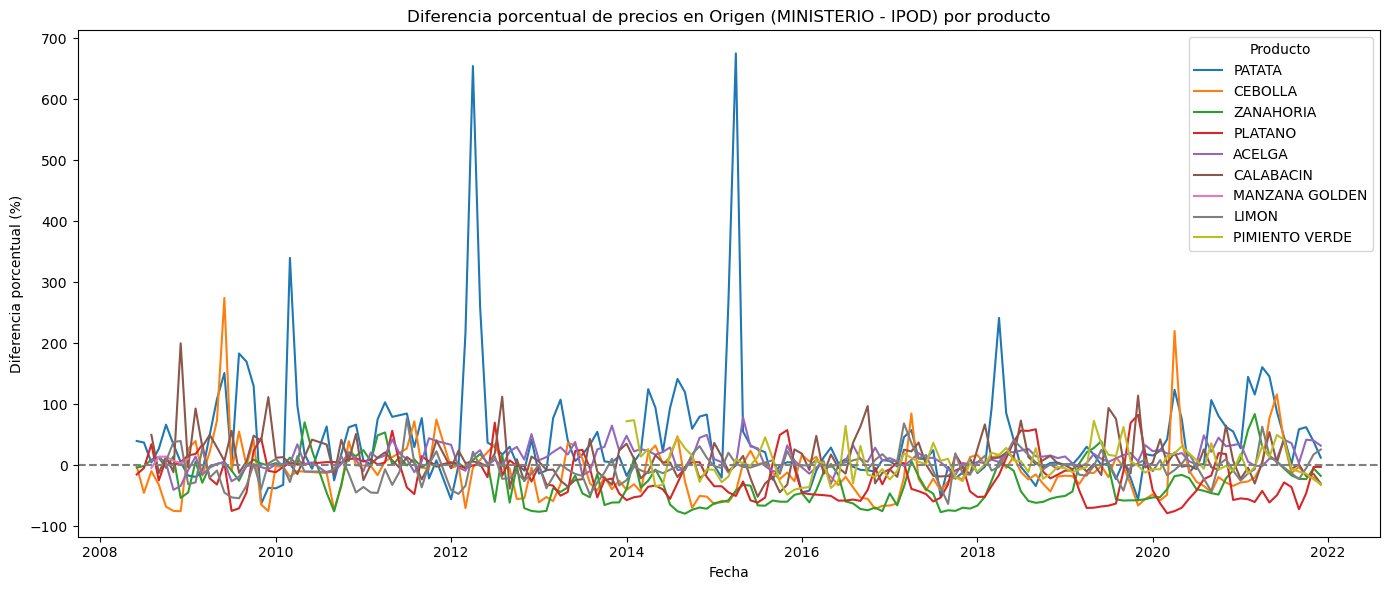

In [399]:
#productos = ["CEBOLLA", "PATATA", "PLATANO"]  # puedes poner los que quieras
productos = ['PATATA', 'CEBOLLA', 'ZANAHORIA', 'PLATANO', 'ACELGA', 'CALABACIN',
       'MANZANA GOLDEN', 'LIMON', 'PIMIENTO VERDE']
plt.figure(figsize=(14, 6))

for producto in productos:
    df_prod = df_comparados[df_comparados["PRODUCTO"] == producto].copy()
    df_prod = df_prod.dropna(subset=["FECHA", "DIFERENCIA_PCT"])
    sns.lineplot(data=df_prod, x="FECHA", y="DIFERENCIA_PCT", label=producto)

plt.axhline(0, color="gray", linestyle="--")
plt.title("Diferencia porcentual de precios en Origen (MINISTERIO - IPOD) por producto")
plt.xlabel("Fecha")
plt.ylabel("Diferencia porcentual (%)")
plt.legend(title="Producto")
plt.tight_layout()
plt.show()

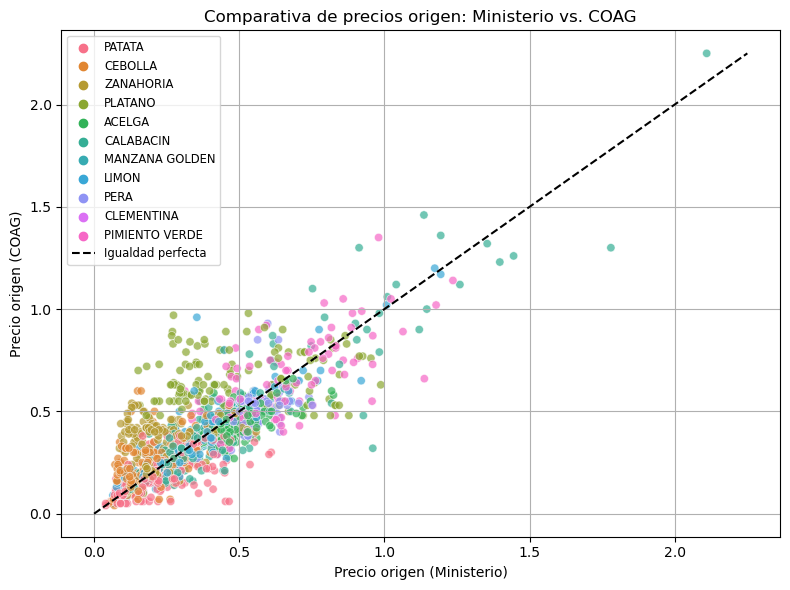

In [645]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_comparados,
    x="PRECIO_ORIGEN_MINIST",
    y="PRECIO_ORIGEN_IPOD",
    hue="PRODUCTO",  # opcional
    alpha=0.7
)

# Línea de referencia perfecta coincidencia
max_val = max(df_comparados["PRECIO_ORIGEN_MINIST"].max(), df_comparados["PRECIO_ORIGEN_IPOD"].max())
plt.plot([0, max_val], [0, max_val], color="black", linestyle="--", label="Igualdad perfecta")

plt.xlabel("Precio origen (Ministerio)")
plt.ylabel("Precio origen (COAG)")
plt.title("Comparativa de precios origen: Ministerio vs. COAG")
plt.legend(loc="upper left", fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()

In [401]:
df_merged = df_merged.rename(columns={
    "PRECIO D": "PRECIO_DESTINO_IPOD",
    "DESTINO": "PRECIO_DESTINO_MINIST" })

In [403]:
# comparados2 es para $ destino
df_comparados2 = df_merged[["PRODUCTO", "YEAR", "MES", "PRECIO_DESTINO_IPOD", "PRECIO_DESTINO_MINIST"]].copy()

In [405]:
df_comparados2["MES_EN"] = df_comparados2["MES"].str.upper().map(meses_esp_to_eng)
df_comparados2["FECHA"] = pd.to_datetime(
    df_comparados2["YEAR"].astype(str) + "-" + df_comparados2["MES_EN"],
    format="%Y-%B",
    errors="coerce" )

In [407]:
df_comparados2["DIFERENCIA_PCT"] = (
    (df_comparados2["PRECIO_DESTINO_MINIST"] - df_comparados2["PRECIO_DESTINO_IPOD"])
    / df_comparados2["PRECIO_DESTINO_IPOD"]) * 100

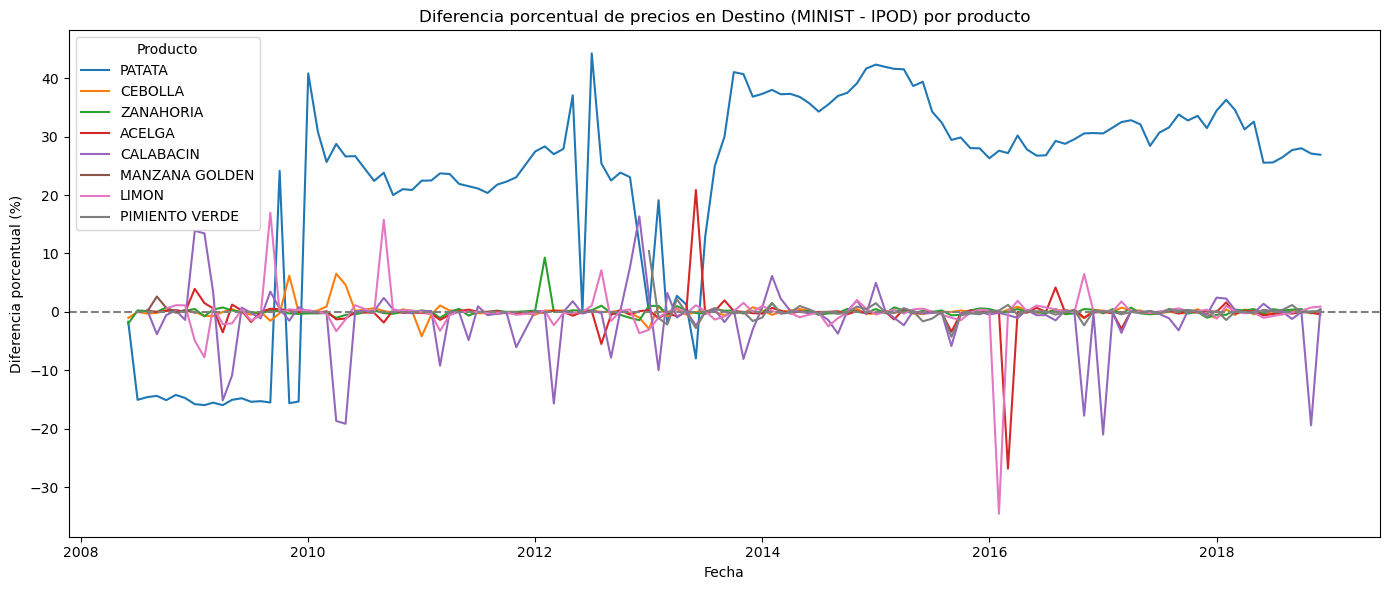

In [409]:
productos = ['PATATA', 'CEBOLLA', 'ZANAHORIA', 'ACELGA', 'CALABACIN',
       'MANZANA GOLDEN', 'LIMON', 'PIMIENTO VERDE'] 
plt.figure(figsize=(14, 6))

for producto in productos:
    df_prod = df_comparados2[df_comparados2["PRODUCTO"] == producto].copy()
    df_prod = df_prod.dropna(subset=["FECHA", "DIFERENCIA_PCT"])
    sns.lineplot(data=df_prod, x="FECHA", y="DIFERENCIA_PCT", label=producto)

plt.axhline(0, color="gray", linestyle="--")
plt.title("Diferencia porcentual de precios en Destino (MINIST - IPOD) por producto")
plt.xlabel("Fecha")
plt.ylabel("Diferencia porcentual (%)")
plt.legend(title="Producto")
plt.tight_layout()
plt.show()

A la luz de las gráficas anteriores, se considera dar un trato especial a la patata. Por un lado, se aprecia como su comportamiento dista mucho del resto de productos y en su caso concreto tiene un caracter especial en el sector de la alimentación. A menudo se utiliza el precio de la patata como indicador general para un gran parte del sector; esto se debe entre otros motivos a tradición y consenso entre vendedores y compradores dada la importancia en los maárgenes que este producto genera.

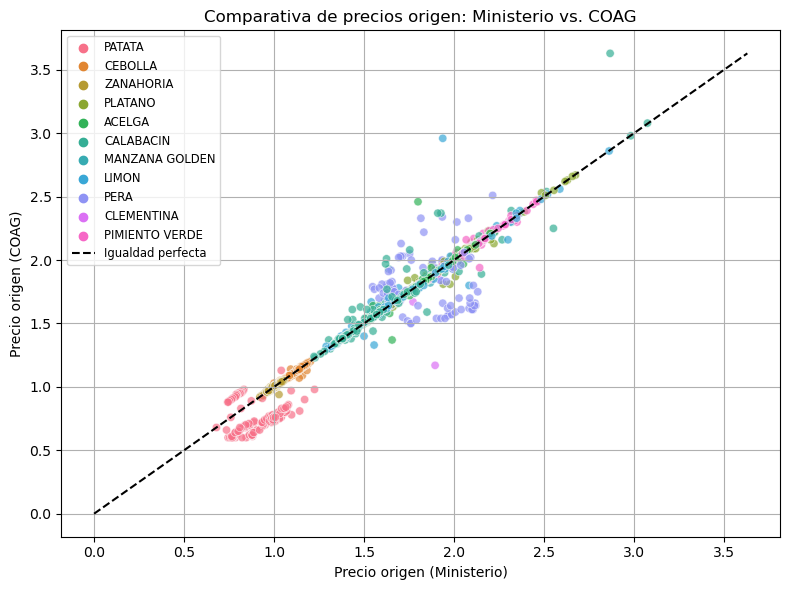

In [651]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_comparados2,
    x="PRECIO_DESTINO_MINIST",
    y="PRECIO_DESTINO_IPOD",
    hue="PRODUCTO",  # opcional
    alpha=0.7
)

# Línea de referencia perfecta coincidencia
max_val = max(df_comparados2["PRECIO_DESTINO_MINIST"].max(), df_comparados2["PRECIO_DESTINO_IPOD"].max())
plt.plot([0, max_val], [0, max_val], color="black", linestyle="--", label="Igualdad perfecta")

plt.xlabel("Precio origen (Ministerio)")
plt.ylabel("Precio origen (COAG)")
plt.title("Comparativa de precios origen: Ministerio vs. COAG")
plt.legend(loc="upper left", fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()

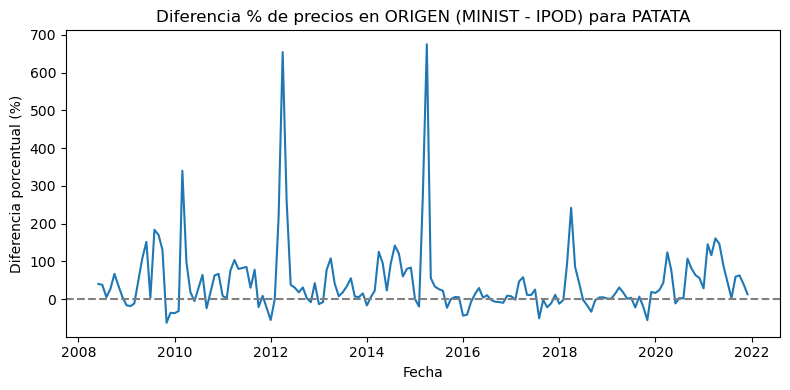

In [621]:
producto = "PATATA"
df_producto = df_comparados[df_comparados2["PRODUCTO"] == producto].copy()

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_producto, x="FECHA", y="DIFERENCIA_PCT")
plt.axhline(0, color="gray", linestyle="--")
plt.title(f"Diferencia % de precios en ORIGEN (MINIST - IPOD) para {producto}")
plt.ylabel("Diferencia porcentual (%)")
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

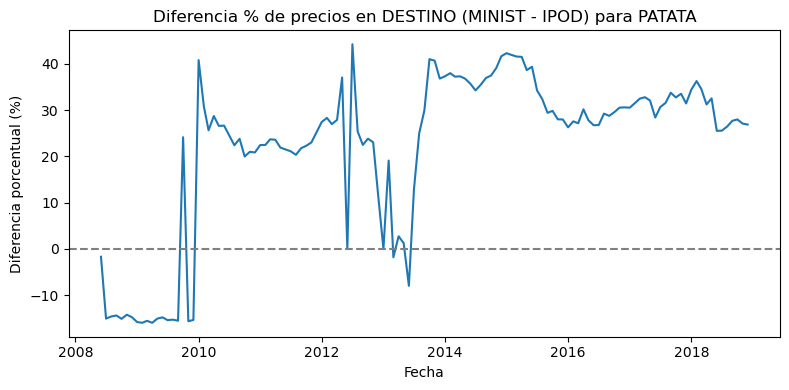

In [623]:
producto = "PATATA"
df_producto = df_comparados2[df_comparados2["PRODUCTO"] == producto].copy()

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_producto, x="FECHA", y="DIFERENCIA_PCT")
plt.axhline(0, color="gray", linestyle="--")
plt.title(f"Diferencia % de precios en DESTINO (MINIST - IPOD) para {producto}")
plt.ylabel("Diferencia porcentual (%)")
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

In [416]:
df_merged = pd.merge(
    df_ipod,
    df_mercabarna,
    on=["PRODUCTO", "YEAR", "MES"],
    how="inner",
    suffixes=("_IPOD", "_MERCABARNA"))

df_merged = df_merged.rename(columns={
    "PRECIO O": "PRECIO_ORIGEN_IPOD",
    "ORIGEN": "PRECIO_ORIGEN_MINIST" })

In [418]:
df_comprado3 = df_merged[["PRODUCTO", "YEAR", "MES", "PRECIO O_IPOD","PRECIO D", "PRECIO O_MERCABARNA"]].copy()
df_comprado3.head(4)

,PRODUCTO,YEAR,MES,PRECIO O_IPOD,PRECIO D,PRECIO O_MERCABARNA
0,PATATA,2015,ENERO,0.04,0.62,0.22
1,CEBOLLA,2015,ENERO,0.22,0.99,0.22
2,COLIFLOR,2015,ENERO,0.62,1.67,1.30
3,CALABACIN,2015,ENERO,1.30,2.16,2.44


In [420]:
df_comprado3["MES_EN"] = df_comprado3["MES"].map(meses_esp_to_eng)

df_comprado3["FECHA"] = pd.to_datetime(
    df_comprado3["YEAR"].astype(str) + "-" + df_comprado3["MES_EN"],
    format="%Y-%B",
    errors="coerce")
#df_comprado3['PRODUCTO'].unique()

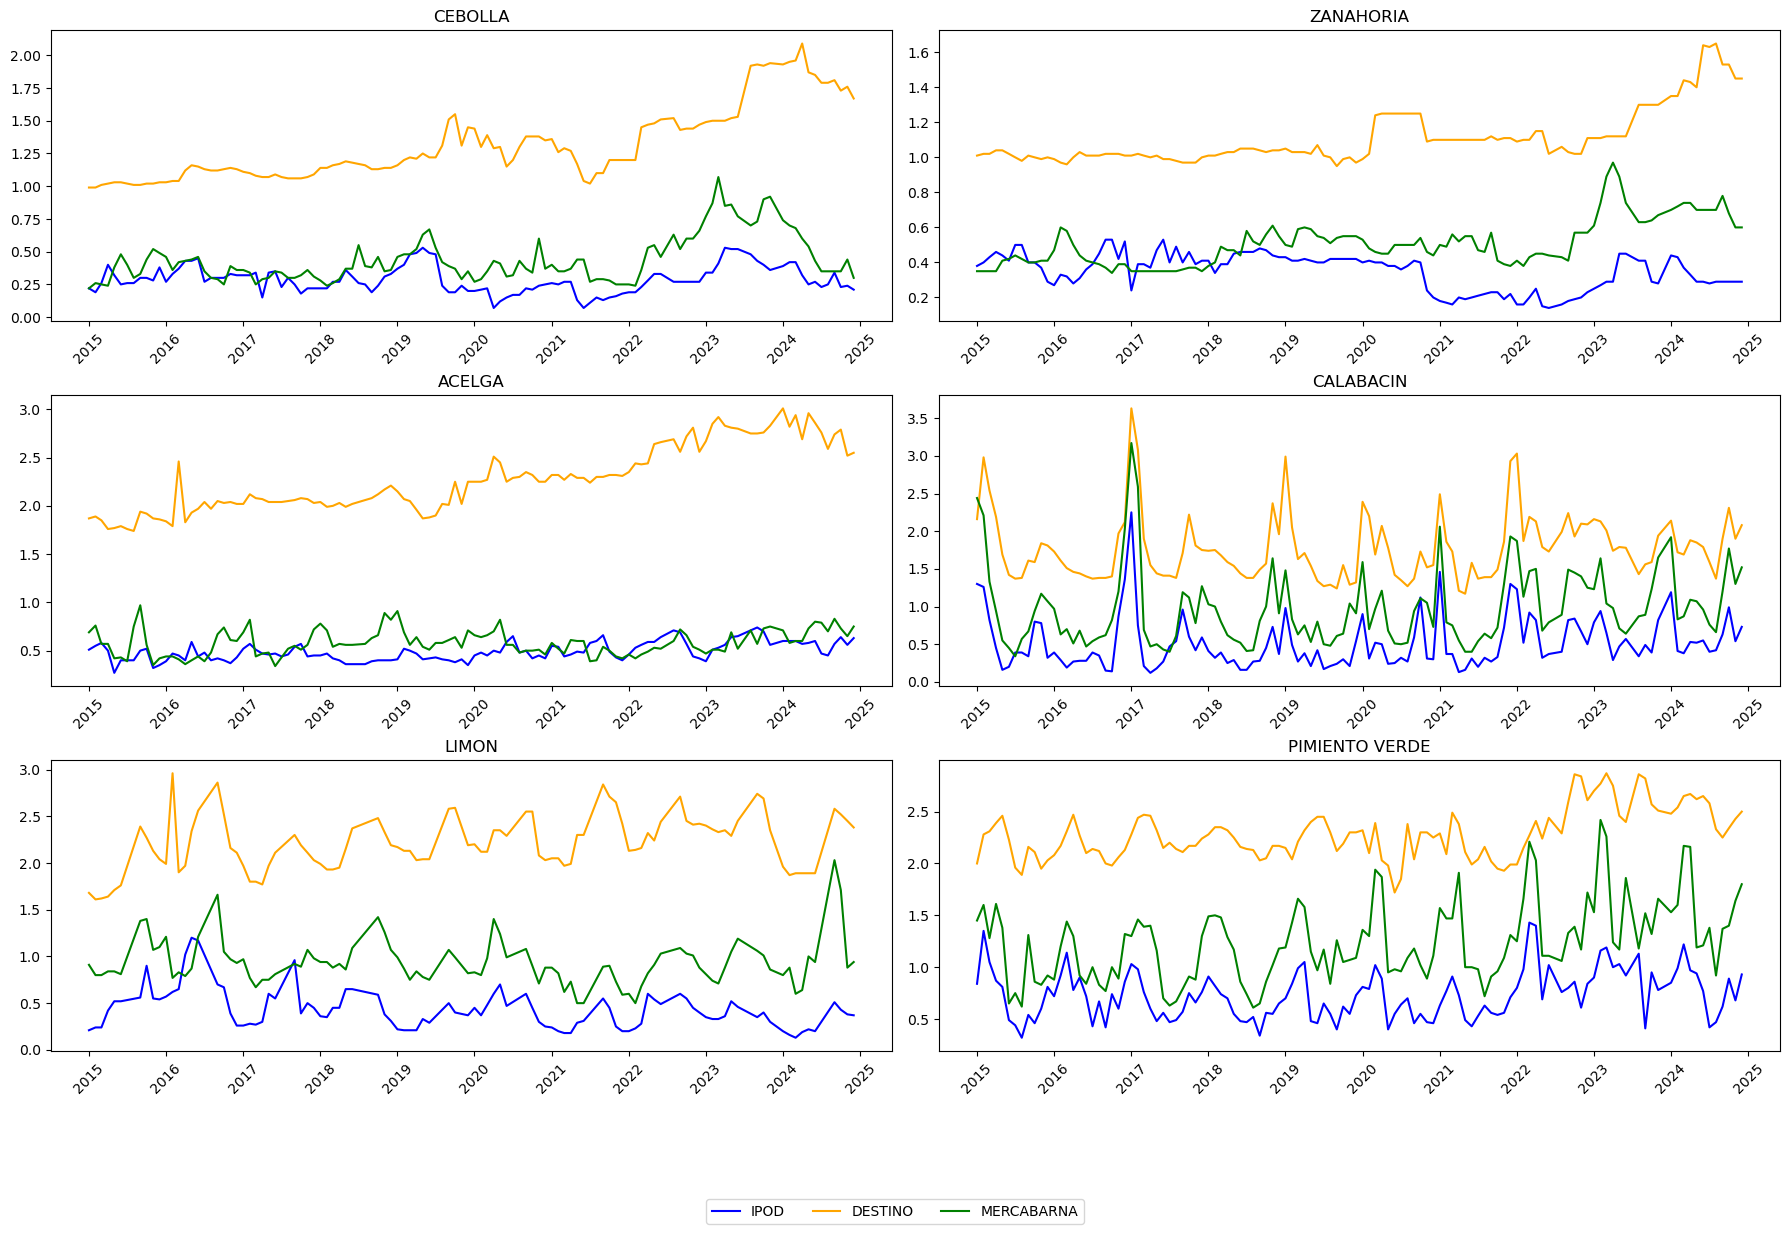

In [422]:
productos = ['CEBOLLA', 'ZANAHORIA', 'ACELGA', 'CALABACIN', 'LIMON', 'PIMIENTO VERDE']

colores = {
    "PRECIO O_IPOD": "blue",
    "PRECIO D": "orange",
    "PRECIO O_MERCABARNA": "green"}

fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=False)
axes = axes.flatten()

for i, producto in enumerate(productos):
    ax = axes[i]
    df_prod = df_comprado3[df_comprado3["PRODUCTO"] == producto].dropna(subset=["FECHA"]).sort_values("FECHA")

    ax.plot(df_prod["FECHA"], df_prod["PRECIO O_IPOD"], label="IPOD", color=colores["PRECIO O_IPOD"])
    ax.plot(df_prod["FECHA"], df_prod["PRECIO D"], label="DESTINO", color=colores["PRECIO D"])
    ax.plot(df_prod["FECHA"], df_prod["PRECIO O_MERCABARNA"], label="MERCABARNA", color=colores["PRECIO O_MERCABARNA"])

    ax.set_title(producto)
    ax.tick_params(axis='x', rotation=45)

handles = [
    plt.Line2D([0], [0], color=colores["PRECIO O_IPOD"], label="IPOD"),
    plt.Line2D([0], [0], color=colores["PRECIO D"], label="DESTINO"),
    plt.Line2D([0], [0], color=colores["PRECIO O_MERCABARNA"], label="MERCABARNA")]

fig.legend(handles=handles, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.03))
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()

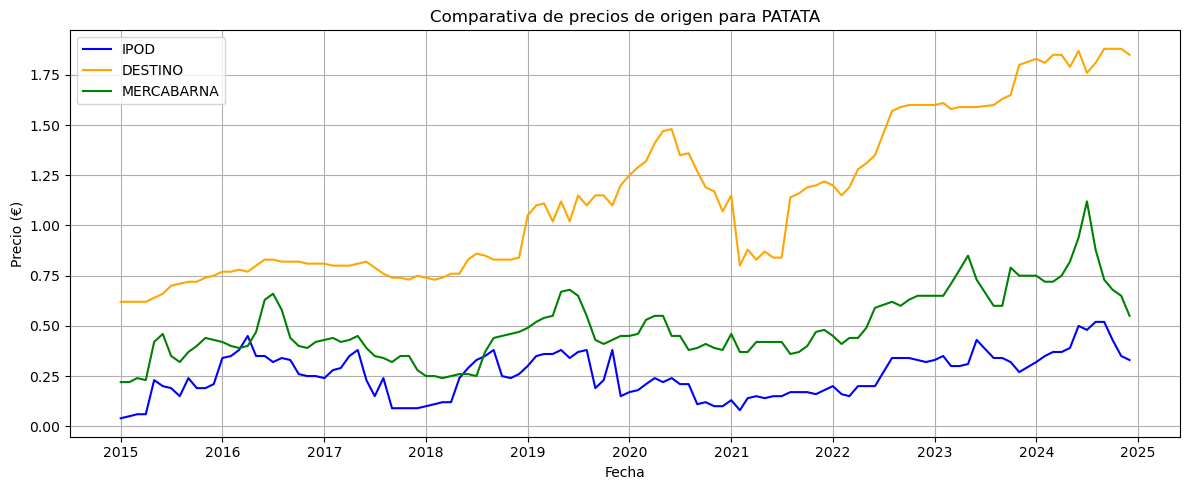

In [423]:
# CASO ESPECIAL PATATA
# Colores fijos por tipo de precio
colores = {
    "PRECIO O_IPOD": "blue",
    "PRECIO D": "orange",
    "PRECIO O_MERCABARNA": "green"}

producto = "PATATA"
df_patata = df_comprado3[df_comprado3["PRODUCTO"] == producto].dropna(subset=["FECHA"]).sort_values("FECHA")

plt.figure(figsize=(12, 5))
plt.plot(df_patata["FECHA"], df_patata["PRECIO O_IPOD"], label="IPOD", color=colores["PRECIO O_IPOD"])
plt.plot(df_patata["FECHA"], df_patata["PRECIO D"], label="DESTINO", color=colores["PRECIO D"])
plt.plot(df_patata["FECHA"], df_patata["PRECIO O_MERCABARNA"], label="MERCABARNA", color=colores["PRECIO O_MERCABARNA"])

plt.title("Comparativa de precios de origen para PATATA")
plt.xlabel("Fecha")
plt.ylabel("Precio (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Unir todos los datos

ojo que ahora la union es outer... no importa si falta algun dato dado que haremos la media de los datos existentes

In [428]:
# Primero: unir IPOD con MERCABARNA
df_tmp = pd.merge(
    df_ipod,
    df_mercabarna,
    on=["PRODUCTO", "YEAR", "MES"],
    how="outer",
    suffixes=("_IPOD", "_MERCABARNA")
)

# Luego: unir el resultado con MINIST
df_merged = pd.merge(
    df_tmp,
    df_minist,
    on=["PRODUCTO", "YEAR", "MES"],
    how="outer"
)

In [430]:
# Crear copia del DataFrame original para evitar modificaciones directas
df_resumen = df_merged.copy()

# Calcular los promedios
df_resumen["ORIGEN"] = df_resumen[["PRECIO O_IPOD", "ORIGEN"]].mean(axis=1)
df_resumen["MERCADO"] = df_resumen[["PRECIO O_MERCABARNA", "MERCASA"]].mean(axis=1)
df_resumen["DESTINO"] = df_resumen[["PRECIO D", "DESTINO"]].mean(axis=1)
df_resumen['dif OD revisada'] = round(df_resumen['DESTINO'] / df_resumen['ORIGEN'],3)
df_resumen["MES_EN"] = df_resumen["MES"].map(meses_esp_to_eng)

df_resumen["FECHA"] = pd.to_datetime(
    df_resumen["YEAR"].astype(str) + "-" + df_resumen["MES_EN"],
    format="%Y-%B",
    errors="coerce")

# Seleccionar solo las columnas necesarias
df_final = df_resumen[["YEAR", "MES_EN","FECHA", "PRODUCTO", "ORIGEN", "MERCADO", "DESTINO","dif OD revisada"]]


In [432]:
df_final.head(4)

,YEAR,MES_EN,FECHA,PRODUCTO,ORIGEN,MERCADO,DESTINO,dif OD revisada
0,2008,November,2008-11-01,ACEITE DE OLIVA VIRGEN,2.20,NaN,3.77,1.714
1,2009,October,2009-10-01,ACEITE DE OLIVA VIRGEN EXTRA,2.44,NaN,3.33,1.365
2,2009,September,2009-09-01,ACEITE DE OLIVA VIRGEN EXTRA,2.49,NaN,3.30,1.325
3,2010,September,2010-09-01,ACEITE DE OLIVA VIRGEN EXTRA,2.00,NaN,3.40,1.700


In [434]:
duplicados = (
    df_final[df_final["PRODUCTO"].isin(['ACELGA', 'CALABACIN', 'CEBOLLA', 'LIMON', 'MANZANA GOLDEN', 'PATATA', 'PERA', 'PIMIENTO VERDE', 'ZANAHORIA'])]
    .groupby(["PRODUCTO", "FECHA"])
    .size()
    .reset_index(name="repeticiones"))

duplicados = duplicados[duplicados["repeticiones"] > 1]
print(len(duplicados))

0


In [437]:
#['ACELGA', 'CALABACIN', 'CEBOLLA', 'LIMON', 'MANZANA GOLDEN', 'PATATA', 'PERA', 'PIMIENTO VERDE', 'ZANAHORIA']

In [439]:
df_final.to_csv("df_final.csv", index=False)

In [443]:
df_agrupado = df_final.groupby("PRODUCTO")["dif OD revisada"].mean().reset_index()
df_agrupado = df_agrupado.sort_values(by="dif OD revisada", ascending=False)
df_agrupado.head(10)

,PRODUCTO,dif OD revisada
173,PIMIENTO CALIFORNIA VERDE,14.867000
156,PATATA (Temprana),10.429000
135,MELON PIEL DE SAPO,9.653000
58,COL,8.850750
172,PIMIENTO CALIFORNIA ROJO,8.567000
115,LIMON FINO,7.852000
56,CLEMENTINA,7.603827
141,NARANJA TIPO NAVEL,7.455484
9,ACEITUNA EN VERDE,7.341875
114,LIMON,6.969925


Agrupando y analizando los valores de Diff (IPOD) son productos poco habituales o de los que hay pocos datos... por eso se obta por analizar los valores de los productos presentes en todas las bases de datos.


In [448]:
df_final = df_final.drop_duplicates()

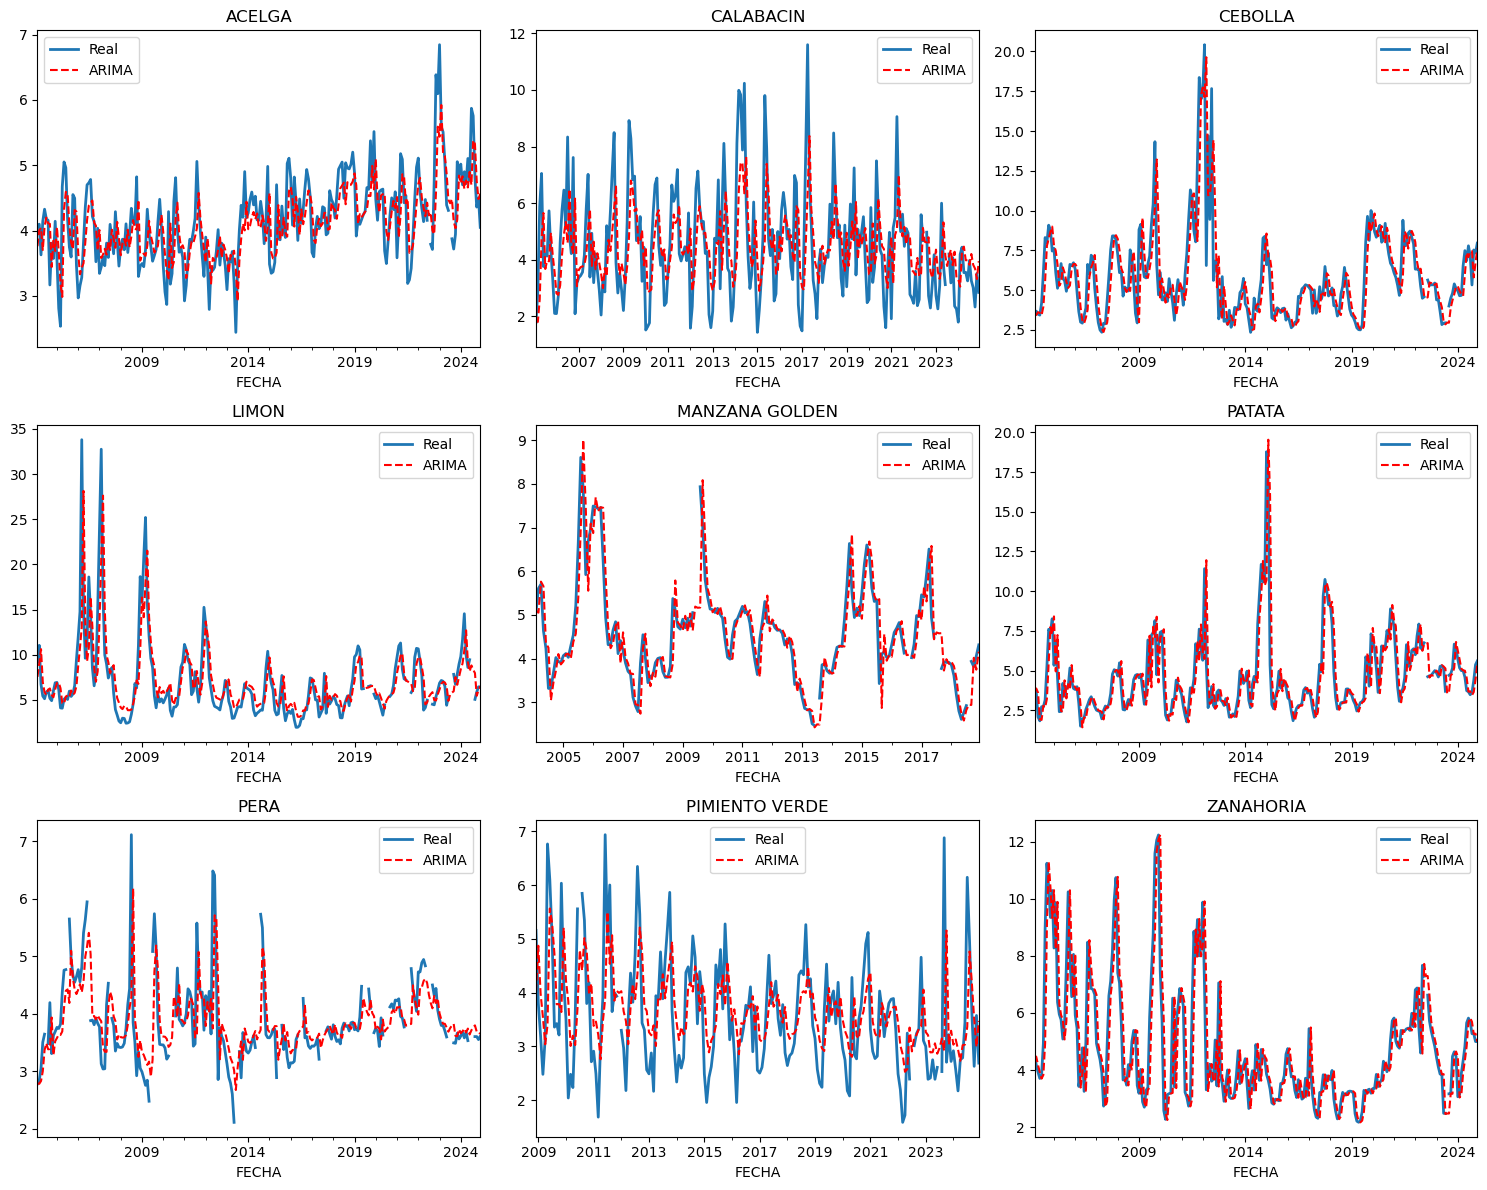

In [450]:
productos_objetivo = ['ACELGA', 'CALABACIN', 'CEBOLLA', 'LIMON', 'MANZANA GOLDEN', 'PATATA', 'PERA', 'PIMIENTO VERDE', 'ZANAHORIA']
# https://nataliaprins.github.io/cursos/Modelos%20autorregresivos/index.html

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Recorrer cada producto y ajustar ARIMA
for i, producto in enumerate(productos_objetivo):
    ax = axes[i]
    
    # Filtrar datos del producto y ordenar por fecha
    df_prod = df_final[df_final["PRODUCTO"] == producto].copy().sort_values("FECHA")
    serie = df_prod.set_index("FECHA")["dif OD revisada"].dropna().asfreq("MS")

    # Verifica que tenga suficientes puntos para ARIMA
    if len(serie) > 12:
        # Ajustar ARIMA(p,d,q) - aquí uso (1,1,1) por simplicidad
        modelo = ARIMA(serie, order=(1, 1, 1))
        resultado = modelo.fit()
        
        # Predicción in-sample
        serie_pred = resultado.predict(start=1, end=len(serie)-1, typ="levels")
        
        # Mostrar original vs predicción
        serie.iloc[1:].plot(ax=ax, label="Real", linewidth=2)
        serie_pred.plot(ax=ax, label="ARIMA", linestyle="--", color="red")
    else:
        ax.text(0.5, 0.5, "Datos insuficientes", ha='center', va='center')
    
    ax.set_title(producto)
    ax.legend()

plt.tight_layout()
plt.show()


usar modelos SARIMA o incluir eventos exógenos (ARIMAX) si se obtiene información adicional.

In [453]:
def aplica_auto_arima(producto):
    df_prod = df_final[df_final["PRODUCTO"] == producto].copy()
    df_prod = df_prod.dropna(subset=["dif OD revisada", "FECHA"])
    df_prod = df_prod.sort_values("FECHA")

    serie = df_prod.groupby("FECHA")["dif OD revisada"].mean()

    # comprobar suficientes datos
    if len(serie) > 24:
        start = time.time()

        modelo = auto_arima(serie, seasonal=True, m=12,
                            suppress_warnings=True, stepwise=True)

        end = time.time()
        print(f"Tiempo de ejecución: {round(end - start, 2)} segundos")

        # Predicción in-sample
        pred = pd.Series(modelo.predict_in_sample(), index=serie.index)

        plt.figure(figsize=(10, 4))
        serie.plot(label="Real", linewidth=2)
        pred.plot(label="ARIMA (auto)", linestyle="--", color="red")
        plt.title(f"ARIMA automático para {producto}")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Datos insuficientes para este producto.")

In [455]:
def aplicar_arima_forecast(producto):
    # Filtrar y preparar la serie
    df_prod = df_final[df_final["PRODUCTO"] == producto].copy()
    df_prod = df_prod.dropna(subset=["dif OD revisada", "FECHA"]).sort_values("FECHA")
    serie = df_prod.groupby("FECHA")["dif OD revisada"].mean()

    # Aplicar auto_arima con control de parámetros
    modelo = auto_arima(
        serie,
        seasonal=True,
        m=12,
        stepwise=True,
        suppress_warnings=True,
        max_order=10,
        max_p=3,
        max_q=3,
        max_d=2,
        error_action="ignore",
        trace=True  # muestra el progreso
    )

    # Forecast a 12 meses
    n_periods = 12
    forecast, conf_int = modelo.predict(n_periods=n_periods, return_conf_int=True)

    # Generar fechas futuras
    ultima_fecha = serie.index.max()
    fechas_forecast = pd.date_range(start=ultima_fecha + pd.offsets.MonthBegin(1), periods=n_periods, freq='MS')

    # Series para graficar
    forecast_series = pd.Series(forecast, index=fechas_forecast)
    conf_int_df = pd.DataFrame(conf_int, index=fechas_forecast, columns=["Lower", "Upper"])

    # Graficar con mejoras
    plt.figure(figsize=(12, 5))
    serie.plot(label="Histórico", linewidth=2)
    forecast_series.plot(label="Forecast", linestyle="--", color="red", linewidth=2)
    plt.fill_between(
        fechas_forecast,
        conf_int_df["Lower"],
        conf_int_df["Upper"],
        color="red",
        alpha=0.2,
        label="Confianza 95%"
    )
    plt.title(f"Predicción futura de 'dif OD revisada' para {producto} (12 meses)")
    plt.xlabel("Fecha")
    plt.ylabel("Valor estimado")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Para posibles ampliaciones se considera la opción de agregar variables exógenas (ARIMAX) en el caso de obtenerla de fuentes autorizadas y poder agregarlar como: clima, eventos excepcionales, precio gasolina, etc... 

Tiempo de ejecución: 10.34 segundos


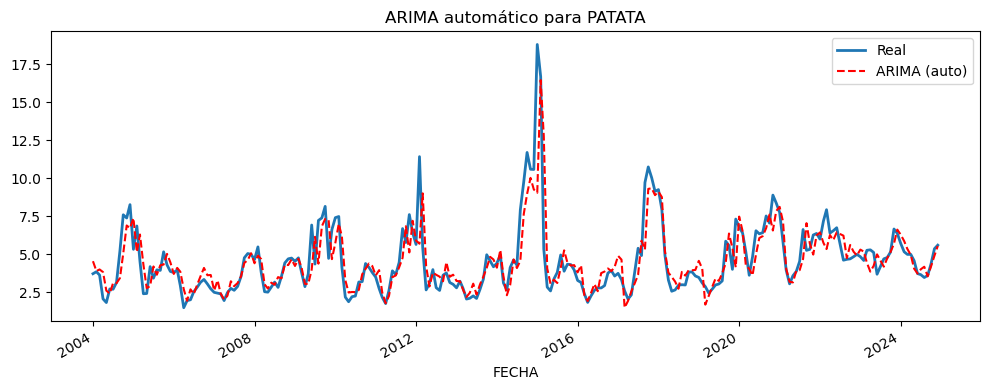

In [458]:
aplica_auto_arima("PATATA")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1131.001, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=891.444, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=967.478, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1528.420, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=895.556, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=887.721, Time=0.37 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=863.910, Time=0.79 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=864.141, Time=0.97 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=863.187, Time=0.69 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=892.312, Time=0.22 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=892.649, Time=0.07 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1084.631, Time=0.74 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   :

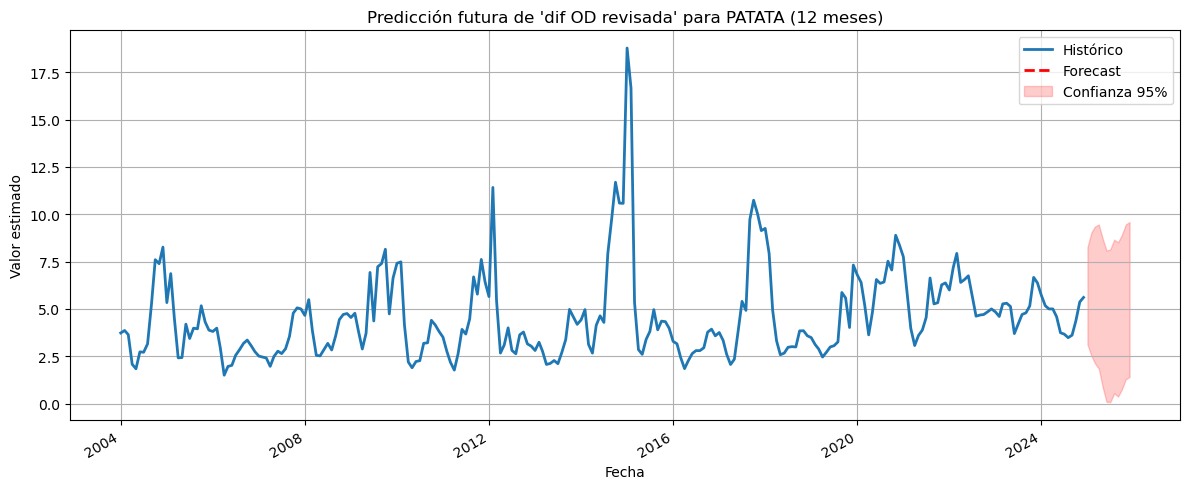

In [462]:
aplicar_arima_forecast('PATATA')

⏱ Tiempo de ejecución: 73.03 segundos


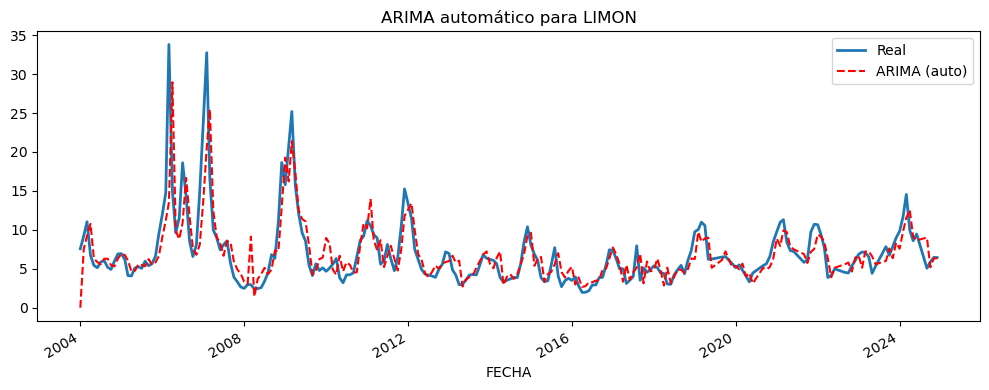

In [371]:
aplica_auto_arima("LIMON")

In [464]:
def predecir_producto(producto):

    df_prod = df_final[df_final["PRODUCTO"] == producto].copy()
    df_prod = df_prod.dropna(subset=["dif OD revisada", "FECHA"]).sort_values("FECHA")
    serie = df_prod.groupby("FECHA")["dif OD revisada"].mean()

    print(f"Serie preparada con {len(serie)} puntos.")

    modelo = auto_arima(
        serie,
        seasonal=True,
        m=12,
        suppress_warnings=True,
        stepwise=True,
        max_order=10,
        max_p=3,
        max_q=3,
        max_d=2,
        error_action="ignore",
        trace=True )

    # Predicción a futuro
    n_periods = 12
    forecast, conf_int = modelo.predict(n_periods=n_periods, return_conf_int=True, alpha=0.2)

    # Crear series
    fechas_forecast = pd.date_range(start=serie.index.max() + pd.offsets.MonthBegin(1), periods=n_periods, freq='MS')
    forecast_series = pd.Series(np.array(forecast, dtype=np.float64), index=fechas_forecast)
    conf_int_df = pd.DataFrame(conf_int, index=fechas_forecast, columns=["Lower", "Upper"])

    # Reintento si hay NaNs
    if forecast_series.isna().any():
        print("Predicción contiene NaN. Reintentando con parámetros más simples...")
        modelo = auto_arima(
            serie,
            seasonal=False,
            max_p=2,
            max_q=2,
            max_d=1,
            suppress_warnings=True,
            stepwise=True,
            error_action="ignore" )
        forecast, conf_int = modelo.predict(n_periods=n_periods, return_conf_int=True, alpha=0.2)
        forecast_series = pd.Series(np.array(forecast, dtype=np.float64), index=fechas_forecast)
        conf_int_df = pd.DataFrame(conf_int, index=fechas_forecast, columns=["Lower", "Upper"])

        if forecast_series.isna().any():
            print("Predicción aún contiene NaN. Revisa la calidad de los datos.")
            return None
        else:
            print("Reintento exitoso. Forecast generado sin NaN.")
    else:
        print("Forecast generado correctamente.")

    # Recorte de histórico reciente
    serie_reciente = serie[serie.index >= serie.index.max() - pd.DateOffset(months=24)]

    # Gráfico
    plt.figure(figsize=(12, 5))
    serie_reciente.plot(label="Histórico (últ. 2 años)", linewidth=2)
    forecast_series.plot(label="Forecast", linestyle="--", color="red", linewidth=2)
    plt.fill_between(forecast_series.index, conf_int_df["Lower"], conf_int_df["Upper"],
                     color="red", alpha=0.2, label="Confianza 80%")
    plt.title(f"Predicción futura de 'dif OD revisada' para {producto} (centrada)")
    plt.xlabel("Fecha")
    plt.ylabel("Valor estimado")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Crear DataFrame final
    df_forecast = pd.DataFrame({
        "FECHA": forecast_series.index,
        "PREDICCIÓN": forecast_series.values,
        "LÍMITE_INFERIOR": conf_int_df["Lower"].values,
        "LÍMITE_SUPERIOR": conf_int_df["Upper"].values
    })

    return df_forecast

Serie preparada con 250 puntos.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1131.001, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=891.444, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=967.478, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1528.420, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=895.556, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=887.721, Time=0.37 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=863.910, Time=0.81 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=864.141, Time=0.99 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=863.187, Time=0.66 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=892.312, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=892.649, Time=0.07 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1084.631, Time=0.78 sec
 ARIMA

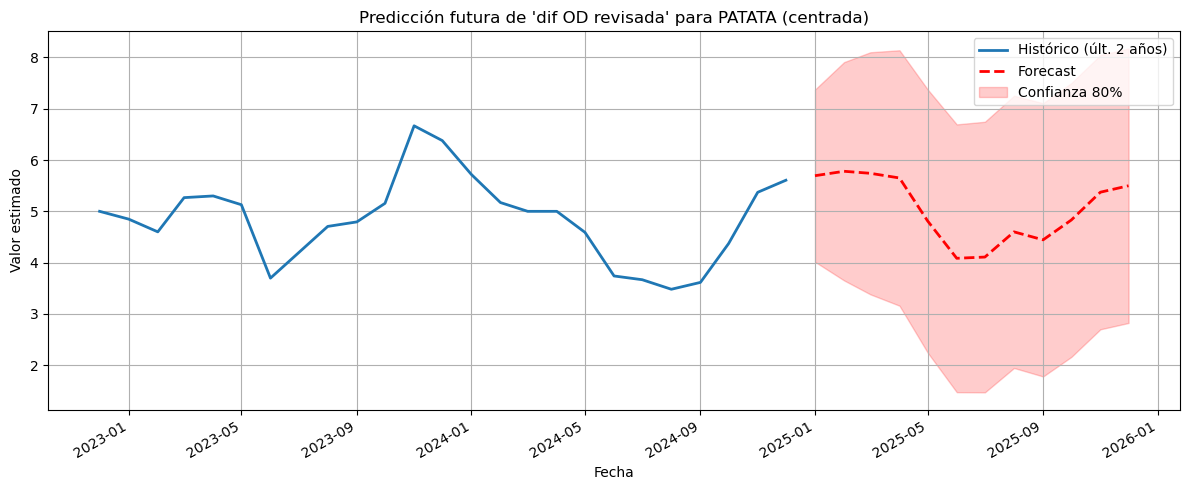

In [466]:
df_patata = predecir_producto('PATATA')

Serie preparada con 239 puntos.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1199.991, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1203.583, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1203.585, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1197.992, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1201.753, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1201.814, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1196.294, Time=0.12 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1187.484, Time=0.31 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1197.362, Time=0.14 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1182.010, Time=0.46 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1182.963, Time=0.34 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=1184.001, Time=0.55 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=1183.994, Time=0

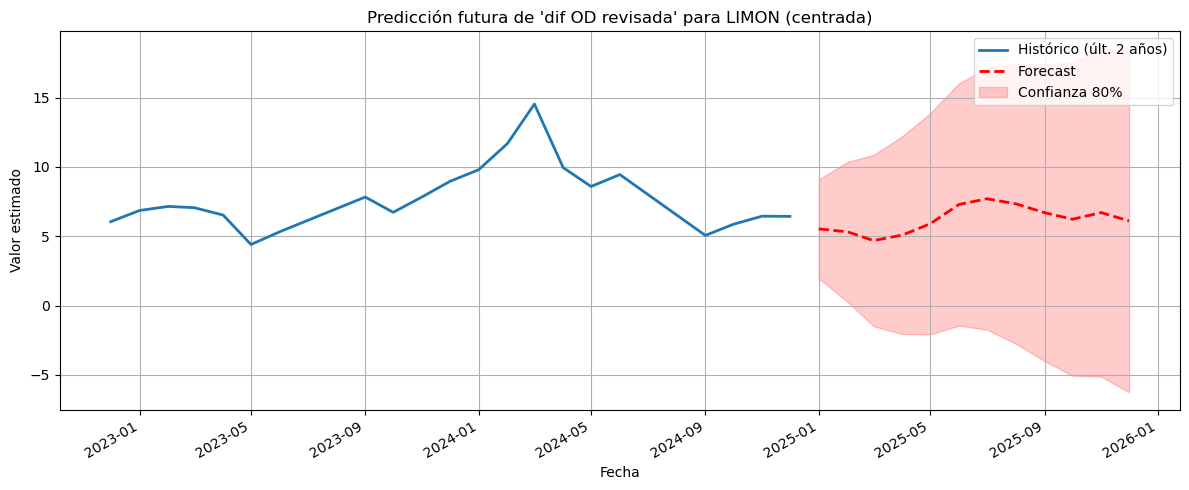

In [468]:
df_limon = predecir_producto('LIMON')

In [476]:
# Clasificar por periodos clave: antes, durante y después del COVID y de sequías
def clasificar_periodo(año):
    if año <= 2019:
        return "ANTES_COVID"
    elif 2020 <= año <= 2021:
        return "COVID"
    elif 2022 <= año <= 2023:
        return "SEQUIA"
    else:
        return "POST_2023"

df_final["PERIODO_EVENTO"] = df_final["YEAR"].apply(clasificar_periodo)
df_eventos = df_final.groupby(["PRODUCTO", "PERIODO_EVENTO"])["dif OD revisada"].mean().reset_index()
df_pivot = df_eventos.pivot(index="PRODUCTO", columns="PERIODO_EVENTO", values="dif OD revisada")


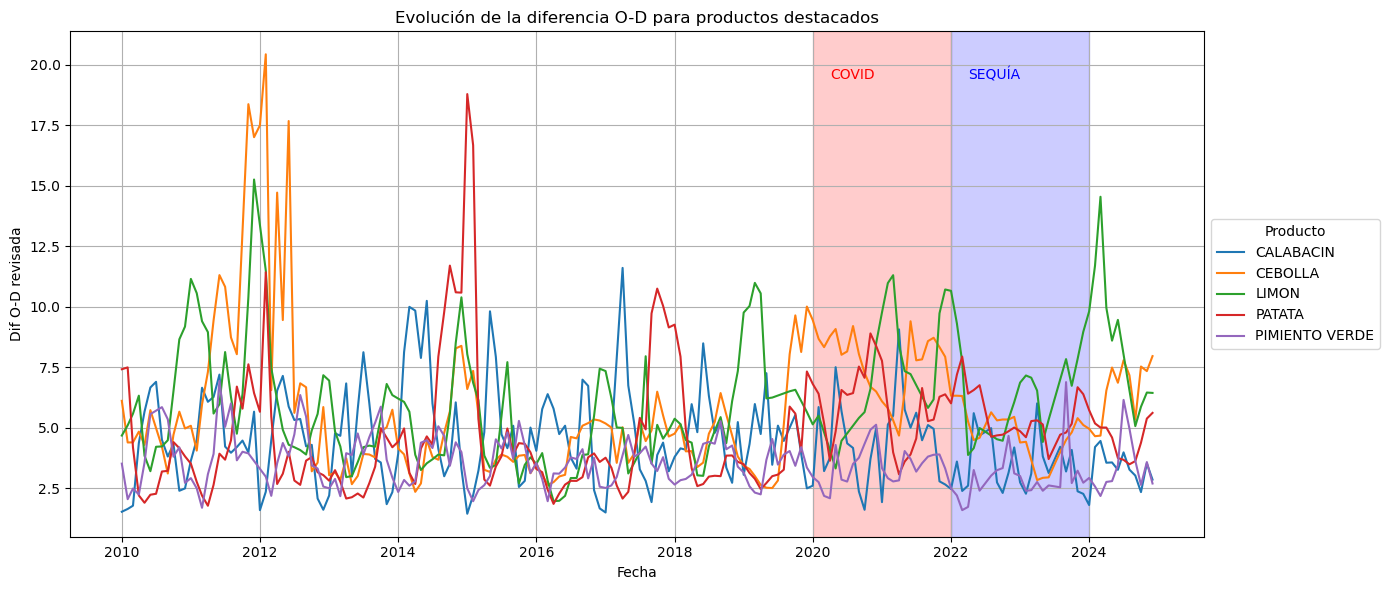

In [499]:
productos_objetivo = ['CALABACIN', 'CEBOLLA', 'LIMON', 'PATATA', 'PIMIENTO VERDE']

df_viz = df_final[
    (df_final["PRODUCTO"].isin(productos_objetivo)) &
    (df_final["FECHA"] >= pd.to_datetime("2010-01-01"))]

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_viz, x="FECHA", y="dif OD revisada", hue="PRODUCTO")
# Franja COVID
plt.axvspan(pd.to_datetime("2020-01-01"), pd.to_datetime("2021-12-31"),
            color="red", alpha=0.2, label=None)
plt.text(pd.to_datetime("2020-01-01") + pd.Timedelta(days=90),
         df_viz["dif OD revisada"].max() * 0.95,
         "COVID", color="red", fontsize=10)

# Franja SEQUÍA
plt.axvspan(pd.to_datetime("2022-01-01"), pd.to_datetime("2023-12-31"),
            color="blue", alpha=0.2, label=None)
plt.text(pd.to_datetime("2022-01-01") + pd.Timedelta(days=90),
         df_viz["dif OD revisada"].max() * 0.95,
         "SEQUÍA", color="blue", fontsize=10)

# Estética general
plt.title("Evolución de la diferencia O-D para productos destacados")
plt.xlabel("Fecha")
plt.ylabel("Dif O-D revisada")
plt.legend(title="Producto", loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


In [563]:
df_sorted = df_final.sort_values(by=['PRODUCTO', 'FECHA'])

# Calcular diferencias entre fehcas/filas consecutivas por producto
df_sorted['CAMBIO_ORIGEN'] = df_sorted.groupby('PRODUCTO')['ORIGEN'].diff()
df_sorted['CAMBIO_DESTINO'] = df_sorted.groupby('PRODUCTO')['DESTINO'].diff()

# Filtrar casos donde cambia DESTINO pero no ORIGEN
cambios_sospechosos = df_sorted[
    (df_sorted['CAMBIO_ORIGEN'].abs() < 1e-5) &  # sin cambio en ORIGEN
    (df_sorted['CAMBIO_DESTINO'].abs() > 0.5)   # cambio en DESTINO 
]

# Mostrar resultados sospechosos
cambios_sospechosos[['FECHA', 'PRODUCTO', 'ORIGEN', 'DESTINO', 'CAMBIO_ORIGEN', 'CAMBIO_DESTINO']]

,FECHA,PRODUCTO,ORIGEN,DESTINO,CAMBIO_ORIGEN,CAMBIO_DESTINO
193,2008-08-01,ACEITUNA,0.75,3.84,0.0,1.24
392,2013-05-01,ACEITUNA ENTAMADA,0.88,4.47,0.0,0.52
1543,2022-02-01,ALCACHOFA,0.70,3.24,0.0,-0.68
5769,2022-11-01,CHAMPIÑON,2.30,4.23,0.0,0.67
6275,2011-05-01,CIRUELA,0.85,2.62,0.0,0.77
15316,2017-06-01,MELOCOTON,0.40,2.56,0.0,-0.96
23375,2023-01-01,TERNERA,5.39,19.84,0.0,0.57
24652,2019-12-01,UVA DE MESA,0.80,3.80,0.0,1.10


In [565]:
cambios_sospechosos['PRODUCTO'].unique()

array(['ACEITUNA', 'ACEITUNA ENTAMADA', 'ALCACHOFA', 'CHAMPIÑON',
       'CIRUELA', 'MELOCOTON', 'TERNERA', 'UVA DE MESA'], dtype=object)

In [574]:
def comparacion(producto):
    df_producto = df_final[df_final['PRODUCTO'] == producto].sort_values('FECHA')

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_producto, x='FECHA', y='ORIGEN', label='Origen', marker='o')
    sns.lineplot(data=df_producto, x='FECHA', y='DESTINO', label='Destino', marker='o')

    plt.title(f'Evolución de precios para "{producto}"')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

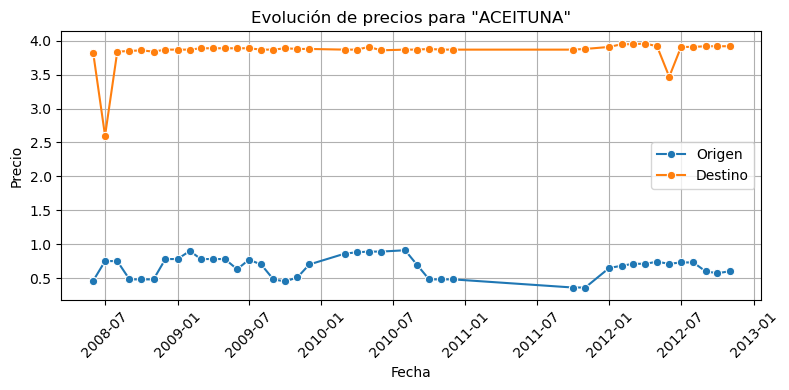

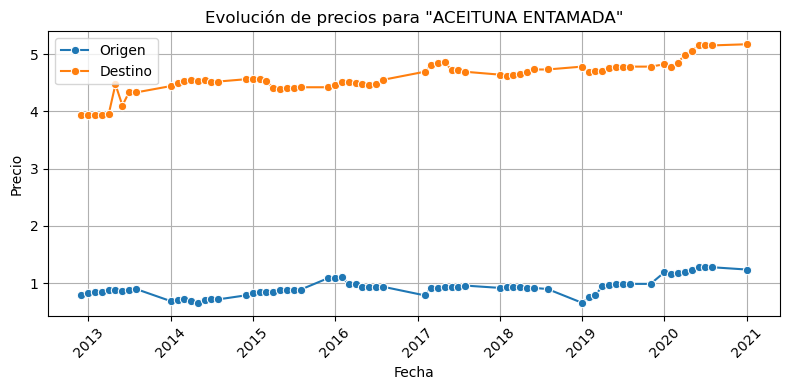

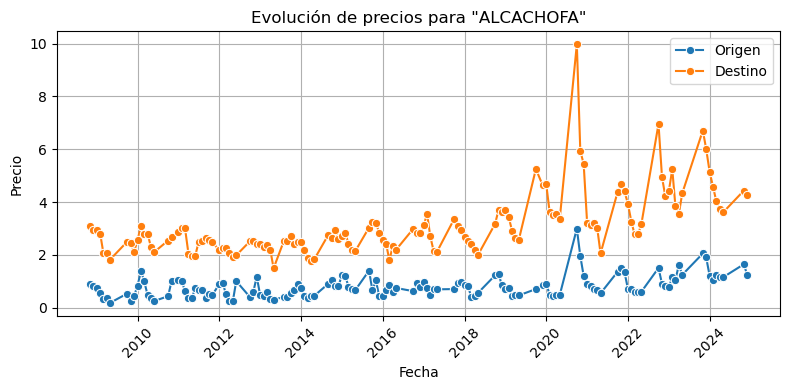

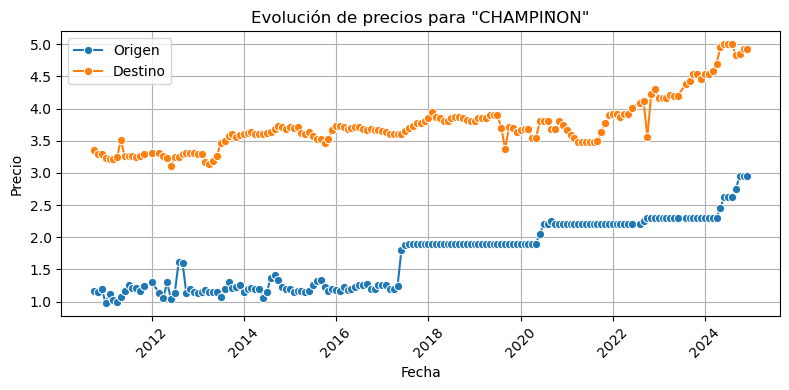

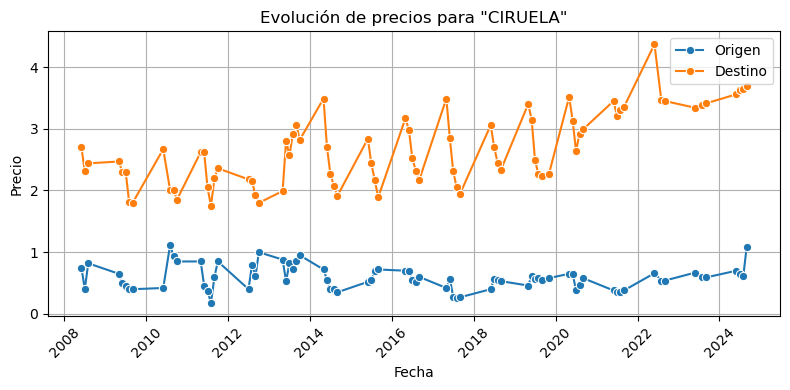

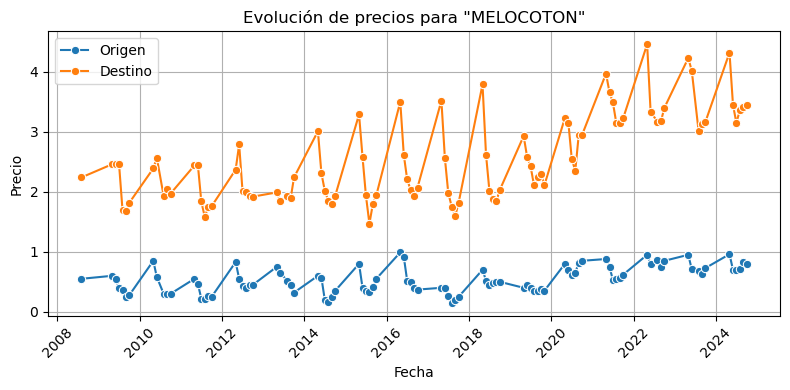

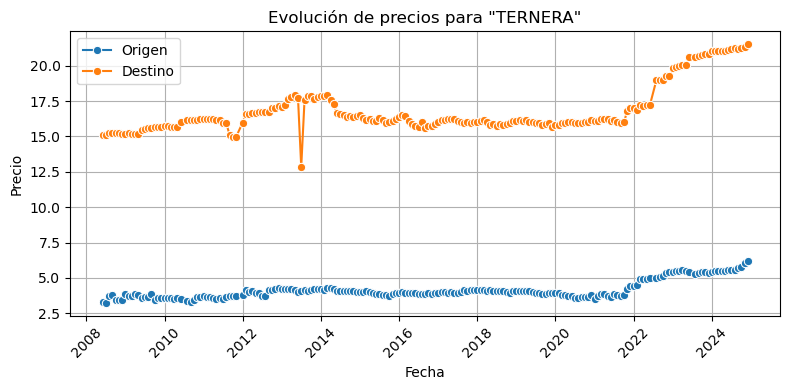

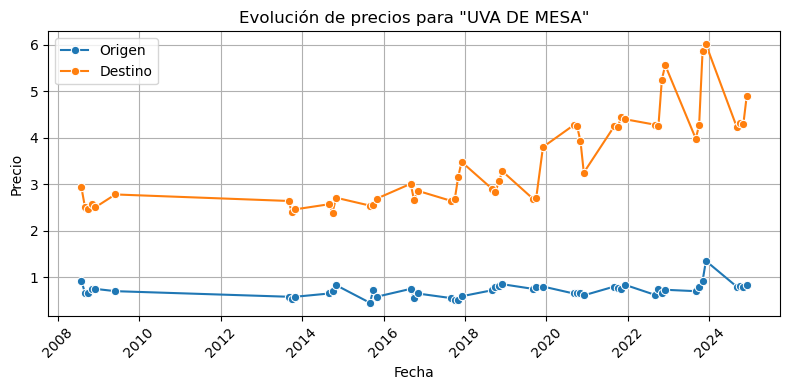

In [576]:
for e in cambios_sospechosos['PRODUCTO'].unique():
    comparacion(e)